# Image Caption Generator with Pytorch 🖼️✨  


This project creates a system that looks at an image and automatically generates a caption that describes it. Think of it as teaching a computer to "see" and "speak" at the same time!  

### What You'll Learn:  
- How computers process images and text.  
- How to build and train a model that generates captions for images.  
- How to evaluate the quality of the captions.  

---

### **What is Image Captioning?**  
```markdown

Image captioning is the process of generating a natural language description for an image.  

Use cases 
- Helps visually impaired people understand images.  
- Automatically tags images for e-commerce or social media.  
- Automation: Saves time for manual tasks like labeling or writing descriptions.  


## The Dataset  

This model was trained on **COCO Dataset** (Common Objects in Context), which consists of over 200,000 labeled images with five captions for each image. Since it's advent in 2014 it has helped significantly in object recognition related tasks. 




## How It Works  

We use Pytorch to train a CNN-LSTM model to generate captions for unseen images.
This system has two parts:  
1. **Image Understanding (Encoder)**:  
   - A computer "looks" at the image and extracts key features using a pre-trained model (ResNet).  

2. **Caption Generation (Decoder)**:  
   - These features are passed to a language model (LSTM) to generate a caption word by word.  

Imagine this process as taking a photo and describing it aloud. The encoder is like your brain recognizing objects, and the decoder is like forming sentences to describe what you see.  


# Importing dependencies

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from PIL import Image
import os
import pickle
import nltk
from pycocotools.coco import COCO
from collections import Counter
import torch.utils.data as data
import torchvision.transforms as transforms
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Downloading Images and their respective annotations

In [2]:
# linux
!apt-get install wget
# mac
# !brew install wget

# create a data directory
!mkdir data_dir

# download images and annotations to the data directory
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir/

# extract zipped images and annotations and remove the zip files
!unzip ./data_dir/annotations_trainval2014.zip -d ./data_dir/
!rm ./data_dir/annotations_trainval2014.zip
!unzip ./data_dir/train2014.zip -d ./data_dir/
!rm ./data_dir/train2014.zip
!unzip ./data_dir/val2014.zip -d ./data_dir/
!rm ./data_dir/val2014.zip

Streaming output truncated to the last 5000 lines.
 extracting: ./data_dir/val2014/COCO_val2014_000000535608.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000279145.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000243495.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000225791.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000428067.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000059383.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000558498.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000376123.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000191304.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000171062.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000014549.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000121152.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000276596.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000029431.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_00000003

# Processing the caption (text) data

We download a dataset to tokenize out texts from the Natural laguage toolkit library. We will use NLTK to build our vocabulary for the texts.

In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Now we build our vocabulary => that is a dictionary that can convert words into numerical tokens.

In [4]:
class Vocab(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.w2i = {}
        self.i2w = {}
        self.index = 0

    def __call__(self, token):
        if not token in self.w2i:
            return self.w2i['<unk>']
        return self.w2i[token]

    def __len__(self):
        return len(self.w2i)
    def add_token(self, token):
        if not token in self.w2i:
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1

def build_vocabulary(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')

    # Add the words to the vocabulary.
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab

vocab = build_vocabulary(json='data_dir/annotations/captions_train2014.json', threshold=4)
vocab_path = './data_dir/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

loading annotations into memory...
Done (t=1.35s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Tokenized the 

# Resize Images
Images can come in different sizes and dimension, now we have to reshape all images that will be passed into the first layer of our CNN model. 
We use image shape of 256 x 256.


In [5]:
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    return image.resize(shape, Image.LANCZOS)

def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = reshape_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_im, output_path))

image_path = './data_dir/train2014/'
output_path = './data_dir/resized_images/'
image_shape = [256, 256]
reshape_images(image_path, output_path, image_shape)

[100/82783] Resized the images and saved into './data_dir/resized_images/'.
[200/82783] Resized the images and saved into './data_dir/resized_images/'.
[300/82783] Resized the images and saved into './data_dir/resized_images/'.
[400/82783] Resized the images and saved into './data_dir/resized_images/'.
[500/82783] Resized the images and saved into './data_dir/resized_images/'.
[600/82783] Resized the images and saved into './data_dir/resized_images/'.
[700/82783] Resized the images and saved into './data_dir/resized_images/'.
[800/82783] Resized the images and saved into './data_dir/resized_images/'.
[900/82783] Resized the images and saved into './data_dir/resized_images/'.
[1000/82783] Resized the images and saved into './data_dir/resized_images/'.
[1100/82783] Resized the images and saved into './data_dir/resized_images/'.
[1200/82783] Resized the images and saved into './data_dir/resized_images/'.
[1300/82783] Resized the images and saved into './data_dir/resized_images/'.
[1400/82

# Instantiate data loader.
We are done with downloading and preprocessing our image captioning data. We will now cast this data into a PyTorch dataset object.

In [6]:
class CustomCocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, data_path, coco_json_path, vocabulary, transform=None, subsample_size=None):
        """Set the path for images, captions and vocabulary wrapper.

        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = data_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys())
        if subsample_size :
          self.indices = self.indices[:subsample_size]
        self.vocabulary = vocabulary
        self.transform = transform

    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        caption = coco_data.anns[annotation_id]['caption']
        image_id = coco_data.anns[annotation_id]['image_id']
        image_path = coco_data.loadImgs(image_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocabulary('<start>'))
        caption.extend([vocabulary(token) for token in word_tokens])
        caption.append(vocabulary('<end>'))
        ground_truth = torch.Tensor(caption)
        return image, ground_truth

    def __len__(self):
        return len(self.indices)


def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).

    We should build custom collate_fn rather than using default collate_fn,
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption).
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch)

    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 256, 256)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 256, 256)
    imgs = torch.stack(imgs, 0)

    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]
    return imgs, tgts, cap_lens

def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco_dataser = CustomCocoDataset(data_path=data_path,
                       coco_json_path=coco_json_path,
                       vocabulary=vocabulary,
                       transform=transform)

    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataser,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_function)
    return custom_data_loader

# Defining the CNN-LSTM model
We use resnet34 architecture from the Pytorch models repository


In [7]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(CNNModel, self).__init__()
        resnet = models.resnet34(weights=True)
        module_list = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)

    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features


class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len

    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(capts)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True)
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs

    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)# hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))# outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)# predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)# inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)# inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)# sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

Training Loop

In [8]:
def validate(encoder, decoder, val_loader, loss_func, device):
    encoder.eval()
    decoder.eval()
    total_val_loss = 0
    with torch.no_grad():
        for imgs, caps, lens in val_loader:
            imgs = imgs.to(device)
            caps = caps.to(device)
            tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]
            features = encoder(imgs)
            outputs = decoder(features, caps, lens)

            loss = loss_func(outputs, tgts)
            total_val_loss += loss.item()

    return total_val_loss / len(val_loader)

def plot_losses(train_loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.title("Training and Validation Loss")
    plt.ylabel('Loss')
    plt.show()

def calculate_bleu_score(encoder, decoder, data_loader, vocabulary, device):
    """
    Calculate BLEU score for the model
    """
    encoder.eval()
    decoder.eval()

    references = []
    hypotheses = []

    with torch.no_grad():
        for imgs, caps, lens in tqdm(data_loader, desc="Calculating BLEU score"):
            imgs = imgs.to(device)

            # Generate caption
            features = encoder(imgs)
            sampled_ids = decoder.sample(features)

            # Convert word_ids to words
            for sample_id, cap in zip(sampled_ids, caps):
                # Generate hypothesis (predicted caption)
                sampled_caption = []
                for word_id in sample_id:
                    word = vocabulary.i2w[word_id.item()]
                    if word == '<end>':
                        break
                    if word not in ['<start>', '<pad>']:
                        sampled_caption.append(word)
                hypotheses.append(sampled_caption)

                # Generate reference (ground truth)
                reference = []
                for word_id in cap:
                    word = vocabulary.i2w[word_id.item()]
                    if word == '<end>':
                        break
                    if word not in ['<start>', '<pad>']:
                        reference.append(word)
                references.append([reference])  # Corpus BLEU expects list of lists

    # Calculate BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    return {
        'BLEU-1': bleu1 * 100,
        'BLEU-2': bleu2 * 100,
        'BLEU-3': bleu3 * 100,
        'BLEU-4': bleu4 * 100
    }

Training loop

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create model directory
if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')

train_loss = []
val_loss = []

# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('/content/data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build data loader
custom_data_loader = get_loader('data_dir/resized_images', 'data_dir/annotations/captions_train2014.json', vocabulary,
                         transform, 128,
                         shuffle=True)

dataset_size = len(custom_data_loader.dataset)
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(custom_data_loader.dataset, [train_size, val_size])

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 128,
    shuffle =  True,
    collate_fn = collate_function
)
val_loader = DataLoader(
    dataset = val_dataset,
    batch_size = 128,
    shuffle=False,
    collate_fn = collate_function
)
# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)


# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

total_train_step = len(train_loader)

best_val_loss = float('inf')

# Training loop with validation and BLEU score calculation
for epoch in range(5):
    encoder_model.train()
    decoder_model.train()
    epoch_train_loss = 0

    for i, (imgs, caps, lens) in enumerate(train_loader):
        # Training steps...
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]

        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)

        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_train_step, loss.item(), np.exp(loss.item())))


    # Calculate average losses
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_loss.append(avg_train_loss)

    # Validate
    current_val_loss = validate(encoder_model, decoder_model, val_loader, loss_criterion, device)
    val_loss.append(current_val_loss)

    # Calculate BLEU scores every epoch
    bleu_scores = calculate_bleu_score(encoder_model, decoder_model, val_loader, vocabulary, device)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/5]')
    print(f'Average Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {current_val_loss:.4f}')
    print('BLEU Scores:')
    for metric, score in bleu_scores.items():
        print(f'{metric}: {score:.2f}')

    # Save best model
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder_model.state_dict(),
            'decoder_state_dict': decoder_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': current_val_loss,
            'bleu_scores': bleu_scores
        }, 'models_dir/best_model.ckpt')



loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
Epoch [0/5], Step [0/2912], Loss: 9.2039, Perplexity: 9936.2709
Epoch [0/5], Step [10/2912], Loss: 5.7390, Perplexity: 310.7585
Epoch [0/5], Step [20/2912], Loss: 5.3749, Perplexity: 215.9103
Epoch [0/5], Step [30/2912], Loss: 5.0663, Perplexity: 158.5872
Epoch [0/5], Step [40/2912], Loss: 4.5573, Perplexity: 95.3224
Epoch [0/5], Step [50/2912], Loss: 4.4355, Perplexity: 84.3934
Epoch [0/5], Step [60/2912], Loss: 4.2940, Perplexity: 73.2602
Epoch [0/5], Step [70/2912], Loss: 4.0093, Perplexity: 55.1095
Epoch [0/5], Step [80/2912], Loss: 3.8978, Perplexity: 49.2948
Epoch [0/5], Step [90/2912], Loss: 3.9339, Perplexity: 51.1072
Epoch [0/5], Step [100/2912], Loss: 3.8149, Perplexity: 45.3734
Epoch [0/5], Step [110/2912], Loss: 3.5603, Perplexity: 35.1747
Epoch [0/5], Step [120/2912], Loss: 3.6513, Perplexity: 38.5266
Epoch [0/5], Step [130/2912], Loss: 3.6395, Perplexity: 38.0744
Epoch [0/5], Step [140/2912

Calculating BLEU score: 100%|██████████| 324/324 [03:00<00:00,  1.79it/s]


Epoch [1/5]
Average Training Loss: 2.6654
Validation Loss: 2.2988
BLEU Scores:
BLEU-1: 38.01
BLEU-2: 20.05
BLEU-3: 11.68
BLEU-4: 6.94
Epoch [1/5], Step [0/2912], Loss: 2.0672, Perplexity: 7.9024
Epoch [1/5], Step [10/2912], Loss: 2.0049, Perplexity: 7.4255
Epoch [1/5], Step [20/2912], Loss: 2.3995, Perplexity: 11.0181
Epoch [1/5], Step [30/2912], Loss: 2.2555, Perplexity: 9.5405
Epoch [1/5], Step [40/2912], Loss: 2.2473, Perplexity: 9.4625
Epoch [1/5], Step [50/2912], Loss: 2.1908, Perplexity: 8.9424
Epoch [1/5], Step [60/2912], Loss: 2.3224, Perplexity: 10.2000
Epoch [1/5], Step [70/2912], Loss: 2.1343, Perplexity: 8.4515
Epoch [1/5], Step [80/2912], Loss: 2.2608, Perplexity: 9.5906
Epoch [1/5], Step [90/2912], Loss: 2.2618, Perplexity: 9.6004
Epoch [1/5], Step [100/2912], Loss: 2.1796, Perplexity: 8.8430
Epoch [1/5], Step [110/2912], Loss: 2.2502, Perplexity: 9.4901
Epoch [1/5], Step [120/2912], Loss: 2.1660, Perplexity: 8.7237
Epoch [1/5], Step [130/2912], Loss: 2.1845, Perplexity: 

Calculating BLEU score: 100%|██████████| 324/324 [03:01<00:00,  1.79it/s]


Epoch [2/5]
Average Training Loss: 2.1824
Validation Loss: 2.1777
BLEU Scores:
BLEU-1: 38.17
BLEU-2: 20.57
BLEU-3: 12.19
BLEU-4: 7.39
Epoch [2/5], Step [0/2912], Loss: 2.0118, Perplexity: 7.4767
Epoch [2/5], Step [10/2912], Loss: 2.2149, Perplexity: 9.1606
Epoch [2/5], Step [20/2912], Loss: 2.0544, Perplexity: 7.8022
Epoch [2/5], Step [30/2912], Loss: 1.9794, Perplexity: 7.2383
Epoch [2/5], Step [40/2912], Loss: 2.1219, Perplexity: 8.3466
Epoch [2/5], Step [50/2912], Loss: 1.9965, Perplexity: 7.3635
Epoch [2/5], Step [60/2912], Loss: 2.0019, Perplexity: 7.4029
Epoch [2/5], Step [70/2912], Loss: 2.0320, Perplexity: 7.6294
Epoch [2/5], Step [80/2912], Loss: 2.0763, Perplexity: 7.9745
Epoch [2/5], Step [90/2912], Loss: 2.0234, Perplexity: 7.5644
Epoch [2/5], Step [100/2912], Loss: 1.8951, Perplexity: 6.6534
Epoch [2/5], Step [110/2912], Loss: 2.0537, Perplexity: 7.7970
Epoch [2/5], Step [120/2912], Loss: 2.0130, Perplexity: 7.4857
Epoch [2/5], Step [130/2912], Loss: 1.9420, Perplexity: 6.

Calculating BLEU score: 100%|██████████| 324/324 [03:01<00:00,  1.78it/s]


Epoch [3/5]
Average Training Loss: 2.0494
Validation Loss: 2.1357
BLEU Scores:
BLEU-1: 38.37
BLEU-2: 20.84
BLEU-3: 12.51
BLEU-4: 7.63
Epoch [3/5], Step [0/2912], Loss: 1.9175, Perplexity: 6.8040
Epoch [3/5], Step [10/2912], Loss: 1.9484, Perplexity: 7.0175
Epoch [3/5], Step [20/2912], Loss: 1.9332, Perplexity: 6.9119
Epoch [3/5], Step [30/2912], Loss: 1.8630, Perplexity: 6.4430
Epoch [3/5], Step [40/2912], Loss: 1.9388, Perplexity: 6.9505
Epoch [3/5], Step [50/2912], Loss: 1.9307, Perplexity: 6.8944
Epoch [3/5], Step [60/2912], Loss: 1.8780, Perplexity: 6.5407
Epoch [3/5], Step [70/2912], Loss: 1.9782, Perplexity: 7.2295
Epoch [3/5], Step [80/2912], Loss: 2.0360, Perplexity: 7.6602
Epoch [3/5], Step [90/2912], Loss: 1.8899, Perplexity: 6.6189
Epoch [3/5], Step [100/2912], Loss: 1.8563, Perplexity: 6.4003
Epoch [3/5], Step [110/2912], Loss: 1.9489, Perplexity: 7.0213
Epoch [3/5], Step [120/2912], Loss: 1.9644, Perplexity: 7.1307
Epoch [3/5], Step [130/2912], Loss: 1.9672, Perplexity: 7.

Calculating BLEU score: 100%|██████████| 324/324 [03:00<00:00,  1.79it/s]


Epoch [4/5]
Average Training Loss: 1.9621
Validation Loss: 2.1227
BLEU Scores:
BLEU-1: 38.90
BLEU-2: 21.31
BLEU-3: 12.89
BLEU-4: 7.96
Epoch [4/5], Step [0/2912], Loss: 1.7362, Perplexity: 5.6760
Epoch [4/5], Step [10/2912], Loss: 1.8395, Perplexity: 6.2937
Epoch [4/5], Step [20/2912], Loss: 1.7888, Perplexity: 5.9823
Epoch [4/5], Step [30/2912], Loss: 1.8696, Perplexity: 6.4856
Epoch [4/5], Step [40/2912], Loss: 1.8534, Perplexity: 6.3817
Epoch [4/5], Step [50/2912], Loss: 1.8602, Perplexity: 6.4248
Epoch [4/5], Step [60/2912], Loss: 1.7574, Perplexity: 5.7973
Epoch [4/5], Step [70/2912], Loss: 1.7249, Perplexity: 5.6120
Epoch [4/5], Step [80/2912], Loss: 1.9475, Perplexity: 7.0112
Epoch [4/5], Step [90/2912], Loss: 1.7298, Perplexity: 5.6393
Epoch [4/5], Step [100/2912], Loss: 1.9072, Perplexity: 6.7341
Epoch [4/5], Step [110/2912], Loss: 1.9065, Perplexity: 6.7297
Epoch [4/5], Step [120/2912], Loss: 1.8716, Perplexity: 6.4989
Epoch [4/5], Step [130/2912], Loss: 1.8643, Perplexity: 6.

Calculating BLEU score: 100%|██████████| 324/324 [03:03<00:00,  1.76it/s]


Epoch [5/5]
Average Training Loss: 1.8952
Validation Loss: 2.1209
BLEU Scores:
BLEU-1: 39.13
BLEU-2: 21.45
BLEU-3: 13.00
BLEU-4: 8.01


```markdown
# BLEU Score

BLEU (Bilingual Evaluation Understudy) score is a metric for evaluating a generated sentence to a reference sentence. It is widely used for evaluating the quality of text which has been machine-translated from one natural language to another. 

 How BLEU Score Works:
- N-gram Precision: BLEU calculates the precision of n-grams (contiguous sequences of n items from a given sample of text) in the candidate sentence with respect to the reference sentence.
- Brevity Penalty: To prevent very short candidate translations from receiving too high a score, BLEU includes a brevity penalty.
- Weights: BLEU can be calculated for different n-grams (unigrams, bigrams, trigrams, etc.) and combines them using a weighted geometric mean.

 BLEU Score Interpretation:
- BLEU-1: Measures the precision of unigrams.
- BLEU-2: Measures the precision of bigrams.
- BLEU-3: Measures the precision of trigrams.
- BLEU-4: Measures the precision of four-grams.

 Usage in Image Captioning:
In the context of image captioning, BLEU score is used to evaluate the quality of the generated captions by comparing them to the reference captions. Higher BLEU scores indicate better performance of the model in generating accurate and relevant captions.

 Example BLEU Scores:
- BLEU-1: 65.0
- BLEU-2: 45.0
- BLEU-3: 30.0
- BLEU-4: 20.0

These scores indicate that the model has a high precision for unigrams but the precision decreases for higher n-grams, which is common in natural language generation tasks.
```

Training vs Validation loss plot

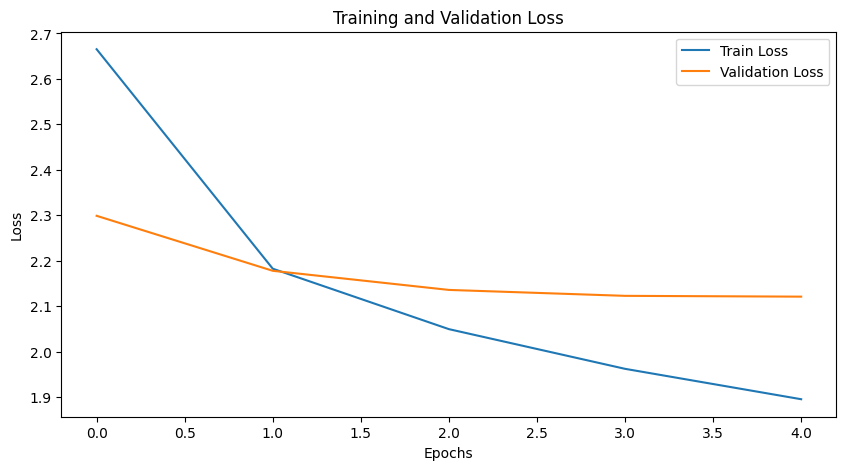

Training completed!
Best validation loss: 2.1209
Final BLEU Scores:
BLEU-1: 39.13
BLEU-2: 21.45
BLEU-3: 13.00
BLEU-4: 8.01


In [11]:
# Plot losses
plot_losses(train_loss, val_loss)

# Print final results
print('Training completed!')
print(f'Best validation loss: {best_val_loss:.4f}')
print('Final BLEU Scores:')
for metric, score in bleu_scores.items():
    print(f'{metric}: {score:.2f}')

In [ ]:
import matplotlib.pyplot as plt

# Making predictions

<ipython-input-15-f1054cdc5e30>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models_dir/best_model.ckpt', map_location=device)


Loaded model from epoch 4 with validation loss: 2.1209
<start> a horse is standing in the middle of a road . <end>


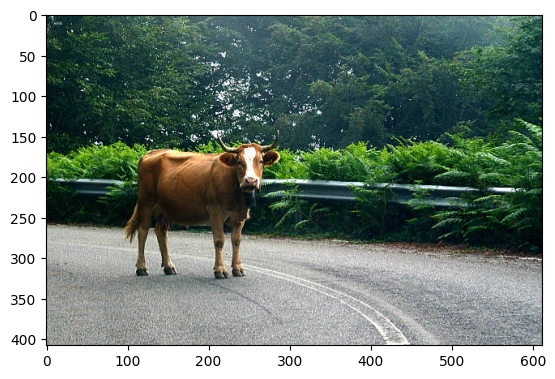

In [15]:
image_file_path = '/content/a cow road.jpg'


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        img = transform(img).unsqueeze(0)

    return img


# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('/content/data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters from the best checkpoint
checkpoint = torch.load('models_dir/best_model.ckpt', map_location=device)
encoder_model.load_state_dict(checkpoint['encoder_state_dict'])
decoder_model.load_state_dict(checkpoint['decoder_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']} with validation loss: {checkpoint['val_loss']:.4f}")


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))